# Analisis causal churn

In [24]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
import matplotlib.pyplot as plt
%matplotlib inline

from causalnex.structure import StructureModel
from causalnex.plots import plot_structure
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork

### preparacion de la data

In [2]:
data=pd.read_csv('data/churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel,ChurnBinary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,Low,Very Low,New,0.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,Low,Moderate,Loyal,0.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Low,Very Low,New,1.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,Low,Moderate,Loyal,0.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Moderate,Very Low,New,1.0


In [3]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'MonthLevel', 'TotalLevel', 'TenureLevel', 'ChurnBinary'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 25 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
MonthLevel          7032 non-nul

In [5]:
def one_hot(df, columns, drop_first=True): 
    dummy=pd.get_dummies(df, 
                         columns=columns, 
                         drop_first=drop_first)
    return dummy

In [6]:
data=data.drop(columns=['customerID', 'Churn'])

In [7]:
data=one_hot(data, ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthLevel', 'TotalLevel', 
                    'TenureLevel', 'InternetService', 'gender'])

In [8]:
data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,ChurnBinary,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,TotalLevel_Low,TotalLevel_Moderate,TotalLevel_Very High,TotalLevel_Very Low,TenureLevel_New,TenureLevel_Regular,TenureLevel_Very Loyal,InternetService_Fiber optic,InternetService_No,gender_Male
0,0,1,29.85,29.85,0.0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
1,0,34,56.95,1889.50,0.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,2,53.85,108.15,1.0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,1
3,0,45,42.30,1840.75,0.0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0,2,70.70,151.65,1.0,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 42 columns):
SeniorCitizen                            7032 non-null int64
tenure                                   7032 non-null int64
MonthlyCharges                           7032 non-null float64
TotalCharges                             7032 non-null float64
ChurnBinary                              7032 non-null float64
Partner_Yes                              7032 non-null uint8
Dependents_Yes                           7032 non-null uint8
PhoneService_Yes                         7032 non-null uint8
MultipleLines_No phone service           7032 non-null uint8
MultipleLines_Yes                        7032 non-null uint8
OnlineSecurity_No internet service       7032 non-null uint8
OnlineSecurity_Yes                       7032 non-null uint8
OnlineBackup_No internet service         7032 non-null uint8
OnlineBackup_Yes                         7032 non-null uint8
DeviceProtection_No internet serv

### red bayesiana

In [10]:
sm=StructureModel()
sm

In [12]:
sm=from_pandas(data)

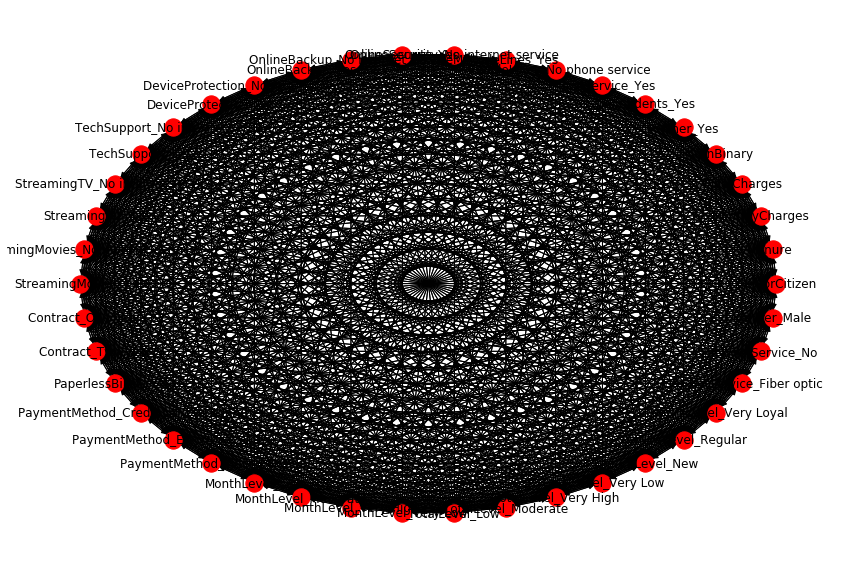

In [16]:
plt.rcParams['figure.figsize']=(12.0, 8.0)

fig, ax, nodes=plot_structure(sm);

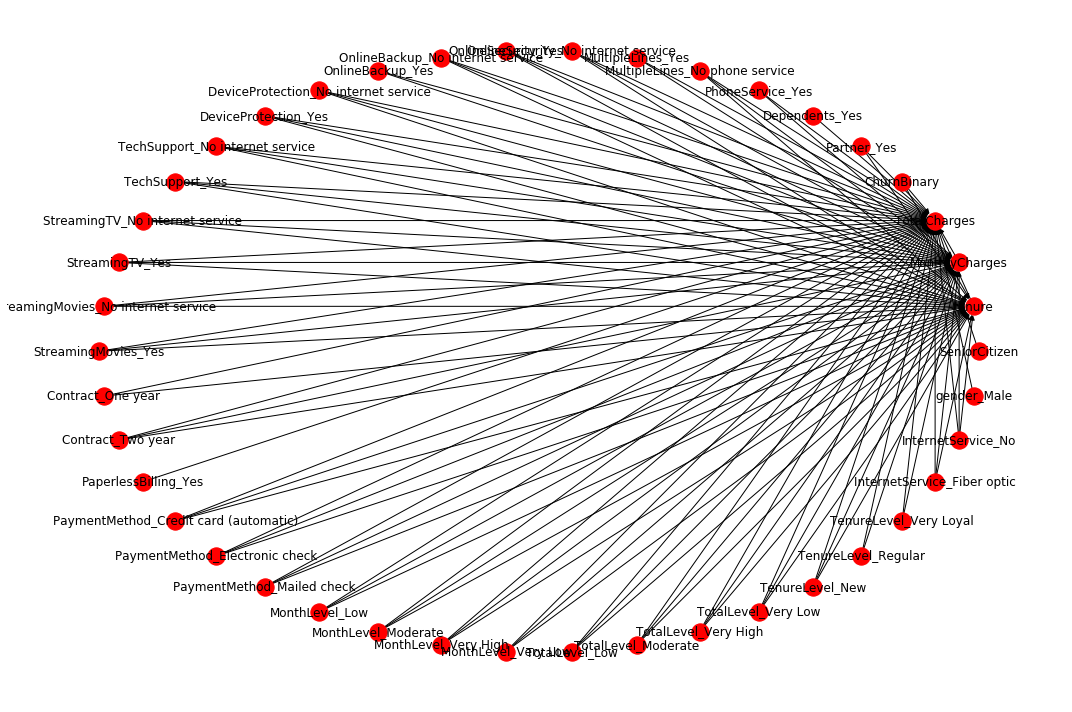

In [22]:
plt.rcParams['figure.figsize']=(15.0, 10.0)



sm.remove_edges_below_threshold(0.99)

fig, ax, nodes=plot_structure(sm);

In [25]:
bn=BayesianNetwork(sm)
bn

In [30]:
bn=bn.fit_cpds(data, method='BayesianEstimator', bayes_prior='K2')

TypeError: 'NoneType' object is not subscriptable

In [ ]:
bn.cpds['ChurnBinary']